In [2]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf

In [3]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # the 'beta' parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initailize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value = w_init(
                shape = (self.embedding_dim, self.num_embeddings), dtype = 'float32'  
            ),
            trainable=True,
            name="embeddings_vqvae",
        )
    
    def call(self, x):
        # Calculate the input shape of the inputs and
        # ten flatten the imputs keeping 'embedding_dim' intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. 
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized)-x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized
    
    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distanced between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices
    

In [96]:
def get_encoder(latent_dim=16):
    #encoder_inputs = keras.Input(shape=(28, 28, 1))
    encoder_inputs = keras.Input(shape=(128, 128, 3))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(
        encoder_inputs
    )
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder")

def get_decoder(latent_dim=16):
    latent_inputs = keras.Input(shape=get_encoder(latent_dim).output.shape[1:])
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(
        latent_inputs
    )
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(3, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [97]:
def get_vqvae(latent_dim=16, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    #inputs = keras.Input(shape=(28, 28, 1))
    inputs = keras.Input(shape=(128, 128, 3))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")

get_vqvae().summary()

Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_144 (InputLayer)      [(None, 128, 128, 3)]     0         
                                                                 
 encoder (Functional)        (None, 8, 8, 16)          132240    
                                                                 
 vector_quantizer (VectorQua  (None, 8, 8, 16)         1024      
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 128, 128, 3)       42051     
                                                                 
Total params: 175,315
Trainable params: 175,315
Non-trainable params: 0
_________________________________________________________________


In [13]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]
    
    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [11]:
# xxx
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_train_scaled = (x_train / 255.0) - 0.5
x_test_scaled = (x_test / 255.0) - 0.5

data_variance = np.var(x_train / 255.0)

In [28]:
import os
from PIL import Image

X_train = []
dataset_path = "/Users/somrawee/Coding/DataSet/CastingProduct/casting_512x512/casting_512x512/ok_front"

image_names = os.listdir(dataset_path)

for i in image_names:
    img = Image.open(dataset_path + '/' + i)
    img = img.resize((128, 128))
    img = np.asarray(img)
    X_train.append(img)

X_train = np.asarray(X_train)
X_train = (X_train.astype(np.float32)-127.5) /127.5

print(X_train.shape)

(519, 128, 128, 3)


In [29]:
dataset = X_train

from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(dataset, test_size=0.2)



data_variance = np.var(x_train / 255.0)

print(x_train.shape)
print(x_test.shape)

(415, 128, 128, 3)
(104, 128, 128, 3)


In [57]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=16, num_embeddings=128)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30


2023-12-26 16:15:13.924154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 2s 199ms/step - loss: 72384.7172 - reconstruction_loss: 72048.9844 - vqvae_loss: 0.0109
Epoch 2/30
4/4 [==============================] - 0s 115ms/step - loss: 70943.1438 - reconstruction_loss: 70278.6875 - vqvae_loss: 0.2834
Epoch 3/30
4/4 [==============================] - 0s 113ms/step - loss: 67831.6875 - reconstruction_loss: 66756.2578 - vqvae_loss: 2.8243
Epoch 4/30
4/4 [==============================] - 0s 114ms/step - loss: 62632.0570 - reconstruction_loss: 61361.9609 - vqvae_loss: 18.3842
Epoch 5/30
4/4 [==============================] - 1s 120ms/step - loss: 56162.5000 - reconstruction_loss: 54890.6758 - vqvae_loss: 92.4894
Epoch 6/30
4/4 [==============================] - 0s 116ms/step - loss: 51611.7617 - reconstruction_loss: 50367.4844 - vqvae_loss: 411.6045
Epoch 7/30
4/4 [==============================] - 0s 113ms/step - loss: 48120.2109 - reconstruction_loss: 46092.6016 - vqvae_loss: 1574.5560
Epoch 8/30
4/4 [======================

In [58]:
trained_vqvae_model = vqvae_trainer.vqvae
idx = np.random.choice(len(x_test), 10)
test_images = x_test[idx]
reconstructions_test = trained_vqvae_model.predict(test_images)



1/1 [==============================] - 0s 199ms/step


2023-12-26 16:15:32.310090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 63ms/step


2023-12-26 16:15:34.932286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(10, 16, 16, 16)
(2560, 16)
(2560,)
(10, 16, 16)


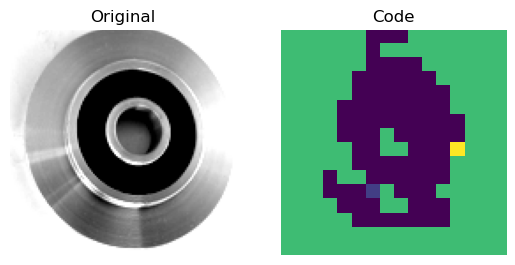

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


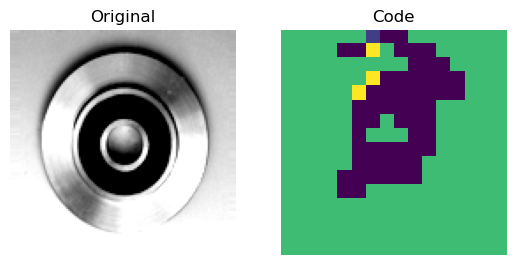

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


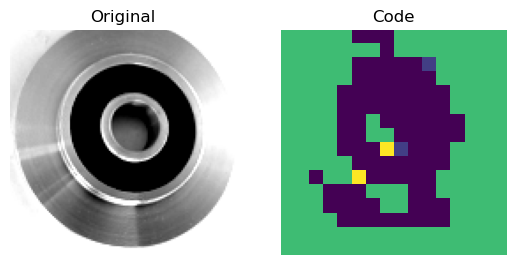

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


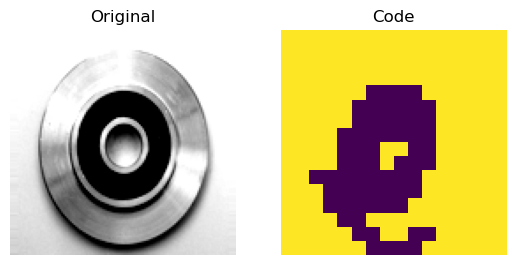

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


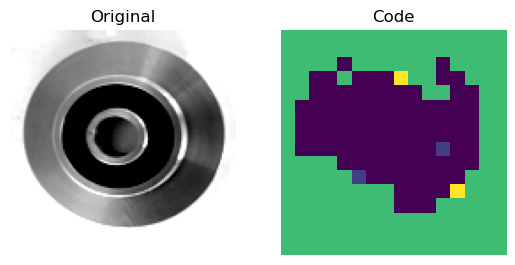

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


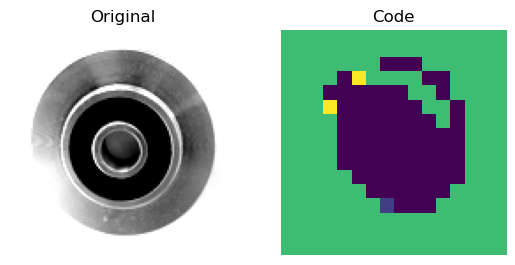

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


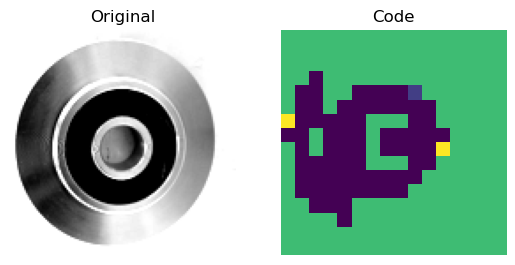

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


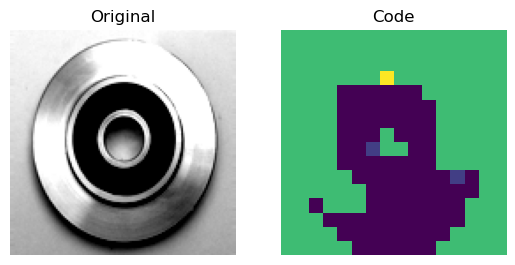

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


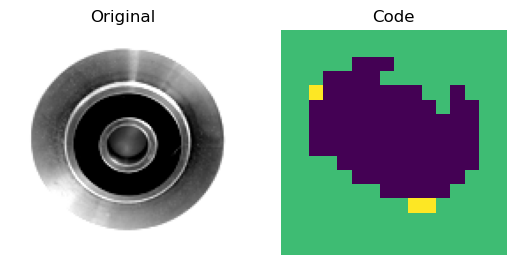

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


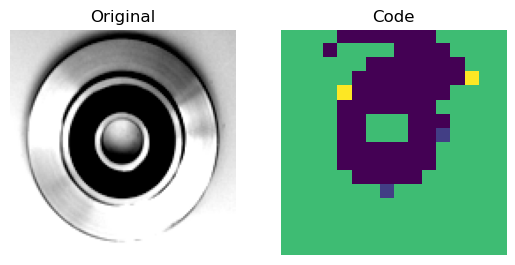

In [59]:
encoder = vqvae_trainer.vqvae.get_layer("encoder")
quantizer = vqvae_trainer.vqvae.get_layer("vector_quantizer")

encoded_outputs = encoder.predict(test_images)
print(encoded_outputs.shape)
flat_enc_outputs = encoded_outputs.reshape(-1, encoded_outputs.shape[-1])
print(flat_enc_outputs.shape)
codebook_indices = quantizer.get_code_indices(flat_enc_outputs)
print(codebook_indices.shape)
codebook_indices = codebook_indices.numpy().reshape(encoded_outputs.shape[:-1])
print(codebook_indices.shape)

for i in range(len(test_images)):
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i].squeeze() + 0.5)
    #plt.imshow(test_images[i])
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(codebook_indices[i])
    plt.title("Code")
    plt.axis("off")
    plt.show()

In [60]:
print(codebook_indices[0].shape)
print(codebook_indices.shape)

(16, 16)
(10, 16, 16)
